In [ ]:
import os

# Define your workspace directory
workspace_dir = '/content/anomaly-detection-in-HEP/code/'

# Create the directory if it doesn't exist
if not os.path.exists(workspace_dir):
    os.makedirs(workspace_dir)

# Change the current working directory to your workspace directory
os.chdir(workspace_dir)

# Verify the current working directory
print('Current working directory:', os.getcwd())


Current working directory: /content/anomaly-detection-in-HEP/code


In [ ]:
from preprocessing.dataset import dataset
from torch.utils.data import DataLoader
# from training.trainer import trainer
# from models.vae import VAE
from models.ode import ode
# from evaluation.evaluator import evaluator
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json
import torch
import os
import sys
from copy import copy
from torchsummary import summary
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Background data

In [ ]:
from google.cloud import storage
from io import BytesIO
import uproot

def get_data_from_root(file_dir:str, bucket_name:str = 'cuda-programming-406720'):
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(file_dir)
        file_contents = BytesIO(blob.download_as_string())
        tree = uproot.open(file_contents)
        data = tree['Delphes']
        return data

data_file = 'QCD_LLP_samples/root-files/qcd_100k.root'
data = get_data_from_root(data_file)
features = ['Track.PT', 'Track.Eta', 'Track.Phi', 'Track.D0', 'Track.DZ']

In [ ]:
from itertools import chain
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

data_train = []
data_test = []
for i in range(5):
  d = data['Track'][features[i]].array().tolist()
  d = list(chain.from_iterable(d))
  data_train.append(d[:20_000])
  data_test.append(d[20_000:21_000])
data_bkg_train = torch.tensor(data_train).T
data_bkg_test = torch.tensor(data_test).T

In [ ]:
# means = data_bkg_train.mean(dim=0)
# stds = data_bkg_train.std(dim=0)

# data_bkg_train = (data_bkg_train - means) / stds
# data_bkg_test =(data_bkg_test - means) / stds
print("Train shape:", data_bkg_train.shape)
print("Test shape:", data_bkg_test.shape)

Train shape: torch.Size([20000, 5])
Test shape: torch.Size([1000, 5])


## Signal data

In [ ]:
import h5py
def get_data_from_h5(file_dir:str, bucket_name:str = 'cuda-programming-406720'):
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(file_dir)
        file_contents = BytesIO(blob.download_as_string())
        with h5py.File(file_contents, 'r') as f:
            dataset = f['Track']
            data = dataset[:10_000]
            d1 = dataset[:10_000]
            d2 = dataset[10_000:10_500]
        return d1, d2

In [ ]:
sig1_train, sig1_test = get_data_from_h5('QCD_LLP_samples/h5-files/500GeV_n3_events_100k_1mm_pileup.h5')
sig2_train, sig2_test = get_data_from_h5('QCD_LLP_samples/h5-files/100GeV_n3_events_100k_1mm_pileup.h5')

In [ ]:
data_sig_train = np.concatenate((sig1_train,sig2_train))
data_sig_test = np.concatenate((sig1_test,sig2_test))

In [ ]:
data_sig_train = torch.tensor([list(data_sig_train[i]) for i in range(data_sig_train.shape[0])])
data_sig_test = torch.tensor([list(data_sig_test[i]) for i in range(data_sig_test.shape[0])])

In [ ]:
# data_sig_train = (data_sig_train - means) / stds
# data_sig_test =(data_sig_test - means) / stds

print("Train shape:", data_sig_train.shape)
print("Test shape:", data_sig_test.shape)

Train shape: torch.Size([20000, 5])
Test shape: torch.Size([1000, 5])


## BDT

In [ ]:
data_train = torch.concatenate((data_sig_train, data_bkg_train))
labels_train = torch.concatenate((torch.ones((data_sig_train.shape[0])), torch.zeros((data_bkg_train.shape[0]))))

In [ ]:
data_train = data_train.detach().numpy()
labels_train = labels_train.detach().numpy()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# bdt_model = SVC(kernel='rbf')
bdt_model = DecisionTreeClassifier(random_state=40)
bdt_model.fit(data_train, labels_train)

DecisionTreeClassifier(random_state=40)

In [ ]:
data_test = torch.concatenate((data_sig_test, data_bkg_test))
labels_test = torch.concatenate((torch.ones((data_sig_test.shape[0])), torch.zeros((data_bkg_test.shape[0]))))

In [ ]:
data_test = data_test.detach().numpy()
labels_test = labels_test.detach().numpy()

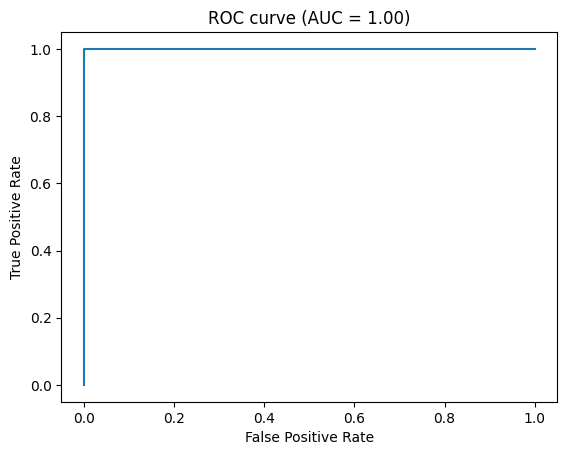

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score

probs = bdt_model.predict_proba(data_test)
fpr, tpr, thresholds = roc_curve(labels_test, probs[:,1])
roc_auc = roc_auc_score(labels_test, probs[:,1])
plt.plot(fpr, tpr)
plt.title('ROC curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig(f'docs/roc-curve-{type_model}.pdf', format='pdf')
plt.show()

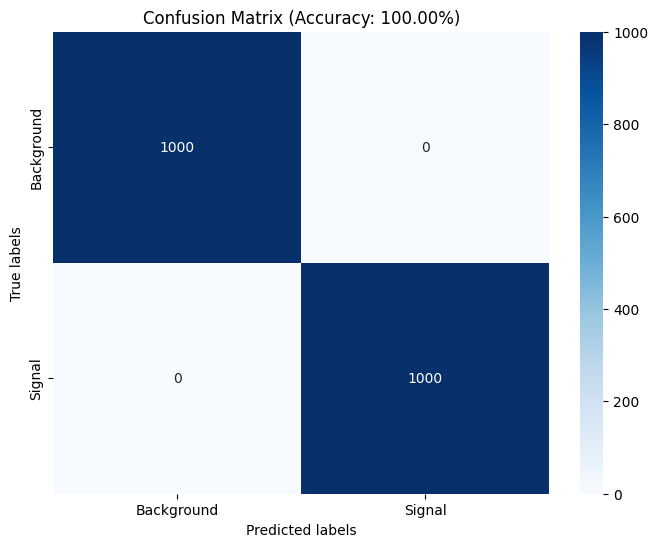

In [ ]:
y_pred = bdt_model.predict(data_test)
cm = confusion_matrix(labels_test, y_pred)
accuracy = accuracy_score(labels_test, y_pred)*100
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Signal"], yticklabels=["Background", "Signal"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Accuracy: {:.2f}%)".format(accuracy))
# plt.savefig(f'docs/cm-{type_model}.pdf', format='pdf')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = bdt_model.predict(data_test)
report = classification_report(labels_test, y_pred)

with open('bdt-classification_report.txt', 'w') as f:
  f.write(report)

print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1000
         1.0       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

